# ML AS 1 



In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [2]:
class MNIST_Dataset(Dataset): 
    def __init__(self,filename): 
        self.data = torch.load(filename)[0]
        self.labels = torch.load(filename)[1]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [3]:
#taken from lady
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [4]:
batch_size = 64
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))


train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
validation_dataloader = DataLoader(mnist_validation, batch_size=batch_size)

mnist_test = MNIST_Dataset("MNIST/processed/test.pt")
test_dataloader = DataLoader(mnist_test, batch_size=batch_size)

len(mnist_real_train), len(mnist_train), len(mnist_validation), len(mnist_test)



(60000, 48000, 12000, 10000)

In [29]:
def train(train_data,valid_data, model, cost, opt, n_epoch = 100, batch_size = 64):
    loss_values = []
    acc_values = []
    batch_size = 64
    n_epoch = n_epoch 

    #early stopping functions
    prev_loss = 10000 #start out of range
    patience = 2 #num epochs to wait 
    triggers = 0 #count depreciation occurances 

    for epoch in range(n_epoch):
        model.train()
        loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        epoch_loss = []
        for X_batch, y_batch in loader:
            X_batch = torch.reshape(X_batch,(batch_size,1,28,28) )
            opt.zero_grad()    
            logits = model(X_batch.float())
            loss = cost(logits, y_batch)
            loss.backward()
            opt.step()        
            epoch_loss.append(loss.detach())
        loss_values.append(torch.tensor(epoch_loss).mean())

        #early stopping check 
        curr_loss = validation(model,device,valid_data,cost)
        print("current loss", curr_loss)
        if curr_loss > prev_loss:
            triggers+=1
            print("early stop trigger:", triggers)
            if triggers > patience: 
                #STOP EARLY 
                print("early stopping at epoch:", epoch)
                return model
        else: 
            triggers = 0 
        prev_loss = curr_loss
        

        model.eval()
        loader = data.DataLoader(train_data, batch_size=len(valid_data), shuffle=False)
        X, y = next(iter(loader))
        X = torch.reshape(X,[len(valid_data),1,28,28])
        logits = model(X.float())
        acc = compute_accuracy(logits, y)
        acc_values.append(acc)

'''validation function developed with inspiration from GFK: Training Neural Networks with Validation using PyTorch and
https://pythonguides.com/pytorch-early-stopping/'''
def validation(model, device, valid_data, loss_funct):
    valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for X,label in valid_loader:  
            outputs = model(X.view(X.shape[0], -1).float())
            loss = loss_funct(outputs, label)
            loss_total += loss.item()


    return loss_total / len(valid_loader)

In [ ]:
'''function to compute accuracy between model probability predictions and expected class value inspired by '''
def compute_accuracy(logits, expect):
    clasPred = logits.argmax(dim=1)
    return (clasPred == expect).type(torch.float).mean()

class SimpleFeedForwardNetwork(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 10),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
batch_size = 64
model = SimpleFeedForwardNetwork().to(device)
opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
train(mnist_train, mnist_validation,model,cost,opt)
#individual model tests
path = input("Please enter a filepath \n > ")
while (path != "exit"):
    img = Image.open(path)
    transform = transforms.ToTensor()
    tensor = transform(img)

    model.eval()              # turn the model to evaluate mode
    with torch.no_grad():     # does not calculate gradient
        class_index = model(tensor).argmax()   #gets the prediction for the image's class
    print("Classifier:" + str(class_index.item()))
    path = input("Please enter a filepath \n > ")

Using cpu device
current loss 1.080829693915996
current loss 1.0453873584245115
current loss 1.0083524511849626
current loss 0.98234841734805
current loss 0.9812764325674544
current loss 0.9436730872443382
current loss 0.9467754062819989
early stop trigger: 1
current loss 0.9597669155039685
early stop trigger: 2
current loss 0.9399593659537904
current loss 0.94635087346777
early stop trigger: 1
current loss 0.9388437657914264
current loss 0.9560707969234344
early stop trigger: 1
current loss 0.9380358010530472
current loss 0.9377844644353744
current loss 0.9255080204060737
current loss 0.9228694822559965
current loss 0.9231852315207745
early stop trigger: 1
current loss 0.9268624560630068
early stop trigger: 2
current loss 0.9272809865626883
early stop trigger: 3
early stopping at epoch: 18


In [31]:
from torchvision import transforms

class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        layers = [nn.Conv2d(1, 5, 3, padding=1)]
        layers.append(nn.LeakyReLU())
        layers.append(nn.MaxPool2d(3, padding=1))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(500, 10))
        
        self.layers = nn.Sequential(*layers
        )

    def forward(self, x):
        x = self.layers(x)
        logits = x
        return logits
    
model = ConvNeuralNetwork().to(device)
print(model)

opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
train(mnist_train, mnist_validation,model,cost,opt)

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

# Three Feed Forwards

Using cpu device
SimpleFeedForwardNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): Tanh()
  )
)


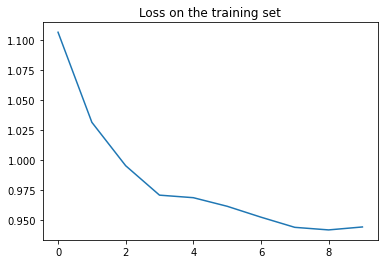

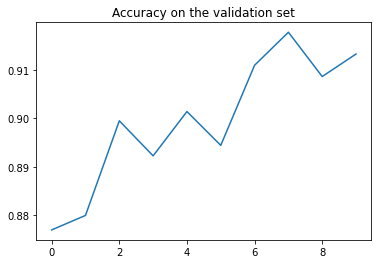

In [11]:
class SimpleFeedForwardNetwork(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 10),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
    
model = SimpleFeedForwardNetwork().to(device)
print(model)

opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 64
n_epoch = 10


for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        X_batch = torch.reshape(X_batch,(batch_size,1,28,28) )
        opt.zero_grad()    
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    X = torch.reshape(X,[len(mnist_validation),1,28,28])
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class ThreeFeedForwardNetwork(nn.Module):
    def __init__(self):
        super(ThreeFeedForwardNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = ThreeFeedForwardNetwork().to(device)
print(model)

opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()




loss_values = []
acc_values = []
batch_size = 64
n_epoch = 10

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        X_batch = torch.reshape(X_batch,(batch_size,1,28,28) )
        opt.zero_grad()    
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    X = torch.reshape(X,[len(mnist_validation),1,28,28])
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

#individual model tests
path = input("Please enter a filepath \n > ")
while (path != "exit"):
    img = Image.open(path)
    transform = transforms.ToTensor()
    tensor = transform(img)

    model.eval()              # turn the model to evaluate mode
    with torch.no_grad():     # does not calculate gradient
        class_index = model(tensor).argmax()   #gets the prediction for the image's class
    print("Classifier:" + str(class_index.item()))
    path = input("Please enter a filepath \n > ")

Using cpu device
ThreeFeedForwardNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


# CNN

In [9]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        layers = [nn.Conv2d(1, 5, 3, padding=1)]
        layers.append(nn.LeakyReLU())
        layers.append(nn.MaxPool2d(3, padding=1))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(500, 10))
        
        self.layers = nn.Sequential(*layers
        )

    def forward(self, x):
        x = self.layers(x)
        logits = x
        return logits
    
model = ConvNeuralNetwork().to(device)
print(model)

opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
train(mnist_train, mnist_validation,model,cost,opt)




ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

In [ ]:
opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 64
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        X_batch = torch.reshape(X_batch,(batch_size,1,28,28) )
        opt.zero_grad()    
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    X = torch.reshape(X,[len(mnist_validation),1,28,28])
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

# print(loss_values)
# print(acc_values)

In [42]:
path = input("Please enter a filepath \n > ")
while (path != "exit"):
    img = Image.open(path)
    transform = transforms.ToTensor()
    tensor = transform(img)
    tensor = torch.reshape(tensor,[1,1,28,28])
    print(tensor)


#     model.eval()              # turn the model to evaluate mode
    with torch.no_grad():     # does not calculate gradient
        
        class_index = model(tensor).argmax()   #gets the prediction for the image's class
    print("Classifier:" + str(class_index.item()))
    path = input("Please enter a filepath \n > ")

Please enter a filepath 
 > MNIST_JPGS/trainingSample/img_13.jpg
tensor([[[[0.0118, 0.0118, 0.0000, 0.0118, 0.0000, 0.0353, 0.0000, 0.0275,
           0.0235, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314,
           0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0275, 0.0235, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0510, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0353, 0.0000, 0.0000, 0.0157, 0.0510, 0.0000, 0.0000,
           0.0118, 0.0196, 0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0235,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0118, 0.0000, 0.0000, 0.0000, 0.0275, 0.0118, 0.0196, 0.0078,
           0.0000, 0.0000, 0.0196, 0.0510, 0.0157, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0078, 0.0118, 0.0118, 0.0000, 0.0000, 0.0235,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0196, 0.0118, 0.0000, 0.0118, 0.0000, 0.0000, 0.0078, 0.0510,
           0.0353, 0.0275, 0.0000, 0.0000, 0.0157, 0.

## CNN with Dropout 

CNNDropNet(
  (layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


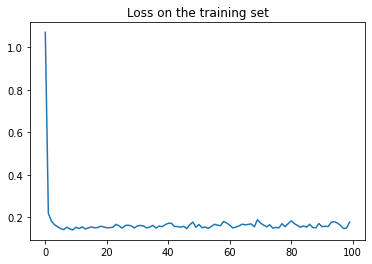

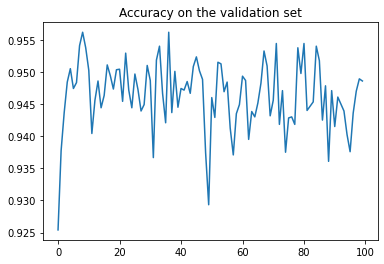

In [227]:
import torch.nn.functional as F
class CNNDropNet(nn.Module):
    def __init__(self):
        super(CNNDropNet, self).__init__()
        layers =  [nn.Conv2d(1, 5, 3, padding=1), 
        nn.LeakyReLU(),
        nn.MaxPool2d(3, padding=1),
        nn.Flatten(), 
        nn.Linear(500, 10)] 
        self.layers = nn.Sequential(*layers)
        
        

    def forward(self, x):
        x = self.layers(x)
        logits = x
        return logits
        

model = CNNDropNet().to(device)
print(model)

opt = optim.Adam(model.parameters(),.01)
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        X_batch = torch.reshape(X_batch,(batch_size,1,28,28) )
        opt.zero_grad()    
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    X = torch.reshape(X,[len(mnist_validation),1,28,28])
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()
# print(loss_values)
# print(acc_values)    
    

# FOLDS

In [30]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

In [211]:
# Configuration parameters for k-fold evaluation 
k_folds = 5
num_epochs = 100

# Array for fold results 
results = {}

# Set fixed random number seed
torch.manual_seed(42)

#concated dataset for folding into new splits 
dataset = ConcatDataset([mnist_train, mnist_test, mnist_validation])


def resetWeights(m):
  '''
      A function to try to reset model weights and avoid leaks
  '''
  for layer in m.children():
   # if the layer can reset than call that funct     
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [ ]:
# Define the cross Validator for the K-fold and suffle to increace variablility 
kfold = KFold(n_splits=k_folds, shuffle=True)
batch_size = 64
#K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

    
    
    
    print('Training process has finished. Saving trained model.')
    acc_values.append(acc)


RuntimeError: Given groups=1, weight of size [16, 1, 5, 5], expected input[1, 128, 28, 28] to have 1 channels, but got 128 channels instead

In [113]:
opt = optim.SGD(model.parameters(),.01)
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

print(loss_values)
print(acc_values)

RuntimeError: Given groups=1, weight of size [16, 1, 5, 5], expected input[1, 128, 28, 28] to have 1 channels, but got 128 channels instead